<a href="https://colab.research.google.com/github/Begum-Guney/python-cltv-machine-learning/blob/main/customer_lifetime_value_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Set Up and Download the Dataset**



In [32]:
# Install required libraries and import them
!pip install openpyxl statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

In [33]:
# Read the data
# # Load both sheets
df_1 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010") # Update the path as needed
df_2 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011") # Update the path as needed

# Merge them
df = pd.concat([df_1, df_2], ignore_index=True)
df.shape, df.head()

# Inspect the data
print(df.head())            # View the first 5 rows
print(df.dtypes)            # Check data types of all columns
print(df.isnull().sum())    # Count missing values per column

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country  

**Step 2: Clean the Data & Prepare for CLTV Modeling**

* Remove rows with missing customer info
* Remove cancelled orders
* Filter to one country (UK) for simplicity
* Create "TotalPrice" column
* Check types & duplicates



In [34]:
# Remove rows with missing "Customer ID"
df = df.dropna(subset=['Customer ID'])

In [35]:
# Remove canceling orders
# Cancelled invoices start with "C"
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [36]:
# Filter to United Kingdom only
df = df[df['Country'] == 'United Kingdom']

In [37]:
# Create "TotalPrice" column
df['TotalPrice'] = df['Quantity'] * df['Price']

In [38]:
# Check types and duplicates
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 725296 entries, 0 to 1067354
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      725296 non-null  object        
 1   StockCode    725296 non-null  object        
 2   Description  725296 non-null  object        
 3   Quantity     725296 non-null  int64         
 4   InvoiceDate  725296 non-null  datetime64[ns]
 5   Price        725296 non-null  float64       
 6   Customer ID  725296 non-null  float64       
 7   Country      725296 non-null  object        
 8   TotalPrice   725296 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 55.3+ MB


np.int64(24862)

**Step 3: Create Features for Customer Lifetime Value (CLTV)**

We’ll create RFM features per customer:

* Recency → Days since last purchase
* Frequency → Number of purchases
* Monetary → Total revenue

Later, we’ll use these features in statsmodels and XGBoost.

In [39]:
# Convert "InvoiceDate" to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [40]:
# Set a reference date (snapshot date)
# We’ll assume we’re analyzing as of one day after the last invoice
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [41]:
# Group by "Customer ID" to create RFM features
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Quick notes:
# df.groupby('Customer ID'): We want one row per customer, so we group the data by customer.
# Inside .agg({ ... }): We're calculating three values per customer
   # 1. 'InvoiceDate': lambda x: (snapshot_date - x.max()).days
      # We take the latest invoice date for each customer: x.max()
      # Then subtract it from snapshot_date
      # This tells us how many days it's been since their last purchase
      # → This is our Recency
   # 2. 'Invoice': 'nunique'
      # We count how many unique invoices this customer had
      # → This gives us Frequency (how many separate purchases)
   # 3. 'TotalPrice': 'sum'
      # We sum all the TotalPrice values (Quantity × Price)
      # → This gives us Monetary (total money spent)

In [42]:
# Check the results
rfm.describe()
rfm.head()
# This gives us a great base for predicting CLTV using regression and ML models

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12608.0,405,1,415.79
2,12745.0,487,2,723.85
3,12746.0,541,1,254.55
4,12747.0,2,26,9276.54



**Step 4: Predict CLTV Using Regression**


* Define CLTV target variable
* Build a regression model using Recency, Frequency, Monetary
* Fit it using statsmodels
* Interpret the results





In [43]:
# Set up the data for regression
# Define independent (X) and dependent (y) variables
# We'll predict the "Monetary" value (total spending) using "Recency" and "Frequency"
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

In [44]:
# Add a constant term to the model (required for intercept)
X = sm.add_constant(X)

In [45]:
# Fit the regression model
model = sm.OLS(y, X).fit()

In [46]:
# Print full model summary with statistical details
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Monetary   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     1397.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:37:43   Log-Likelihood:                -56784.
No. Observations:                5353   AIC:                         1.136e+05
Df Residuals:                    5350   BIC:                         1.136e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1296.3783    216.218     -5.996      0.0

**Analysis of the Results**

**Model fit**
* **R-squared:** Closer to 1 is better.

R-squared: 0.343 – model explains 34.3% of the variance in total spending (Monetary) — this is decent for customer behavior data with only 2 features. Higher = better.
* **F-statistic:** Tests the model’s global validity

F-statistic: 1397 - Tests if the model is better than a horizontal line.
* **Prob (F-statistic):** 0.000 - p-value for the F-test. Since it's near zero, the overall model is statistically significant. (p < 0.05)

**Conclusion:** The model fits reasonably well for a basic one — it captures meaningful patterns, especially via frequency.

**Coefficients Table**

* **for "const"** coef: –1296.38 and p-value: 0.000 -	When Recency = 0 and Frequency = 0, expected spend would be negative — this is a modeling limitation (we’ll fix later).
* **for "Recency"**	coef: +1.52 and p-value: 0.022 - For each extra day since last purchase, expected spend increases by 1.52 units — this might be counterintuitive, so we should re-check this with transformed variables later.
* **for "Frequency"** coef: +596.44and p-value: 0.000	For each extra order, customer spend increases by 596 units — this is the strongest and most meaningful signal in the model.

**Statistical Significance**

All p-values < 0.05 → All features are **statistically significant**.

Coefficients are **not close to zero**, so they have **practical significance too**.

**Residuals & Distribution Warnings**

* **Skew:** 32.4 - Distribution of errors is highly skewed (not symmetric) — likely due to large outliers (some customers spend way more).

Skew Value Range	Meaning
* ≈ 0: Perfectly symmetric
* 0 to ±1: Mild skew (acceptable)
* '> ±2: High skew (problematic)

**Kurtosis:** 1620 - Very heavy tails — means extreme spenders exist.

Kurtosis tells how heavy the tails of your distribution are.

Normal distribution has kurtosis ≈ 3

Kurtosis Value Range	Meaning
* ≈ 3: Normal kurtosis (ideal)
* '> 3: Heavy tails (outliers exist)
* '> 10: Very extreme (likely poor model fit)

**Business Insight Summary**
**Frequency** = most important

**Recency** = possibly misleading now; we’ll explore further.

The model has room for improvement, especially with more features or transformations.

Now, we’ll **log-transform the target (Monetary) to improve our regression model**. Then we’ll move on to **XGBoost for a stronger comparison**.

**Step 5: Log-Transform Monetary & Refit the Regression Model**

Why?

Previous model had extreme skew and kurtosis — this breaks OLS assumptions. (OLS: Ordinary Least Squares — it’s the method behind the regression we ran with statsmodels)

A log transformation often makes the distribution:
* Less skewed
* More normal
* More stable (less effect from extreme outliers)

In [47]:
# Add a new column for log-Monetary
# We'll filter out values ≤ 0 first to avoid log errors
rfm_log = rfm[rfm['Monetary'] > 0].copy()
rfm_log['LogMonetary'] = np.log(rfm_log['Monetary']) # We basically take the log of the "Monetary" values

In [48]:
# Prepare the regression variables
X_log = rfm_log[['Recency', 'Frequency']]
X_log = sm.add_constant(X_log)
y_log = rfm_log['LogMonetary']

In [49]:
# Fit the log-regression model
log_model = sm.OLS(y_log, X_log).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:            LogMonetary   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     2265.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:38:47   Log-Likelihood:                -7674.9
No. Observations:                5350   AIC:                         1.536e+04
Df Residuals:                    5347   BIC:                         1.538e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9022      0.022    307.498      0.0

** OLS Regression Results with "LogMonetary"**

**Model Fit**
* **R-squared:**	0.459 - The model now explains 45.9% of the variation in customer spend (log scale) — much better than before (34%)
* **F-statistic:**	2265 - Strong evidence that the model is better than a constant-only model
* **Prob (F-statistic):**	0.000 - Model is statistically significant overall.

**Conclusion:** Log-transforming the target improved the model — more accurate, less noisy.

**Coefficients Table (Interpretation)**
* **"const" coef:** 6.9022 - Base log spend level for customers with Recency = 0 and Frequency = 0.
* **"Recency" coef:** -0.0023 - As Recency increases, predicted spend decreases — now it makes sense!
* **"Frequency" coef:** 0.0567 - Each additional purchase increases predicted log spend — strong and logical relationship.

**All p-values < 0.05 → All features are statistically significant.**

Now, the Recency coefficient is negative, which matches business expectations:
More recent = more valuable customer.

**Residual Distribution (Skew & Kurtosis)**

* **Skew:** –1.17 - Much better! Still slightly left-skewed, but far from the previous 32.
* **Kurtosis:** 14.57 - Still heavy-tailed, but down from 1600+ — big improvement.

**Log transformation really helped** with distributional issues.

**Step 6: Train the XGBoost Model to Predict CLTV**

We’ll use "Recency" and "Frequency" to predict "Monetary" (raw, not log this time), and compare performance with linear regression.

**Quick note:**

**XGBoost** is a fast and powerful machine learning library that builds models using many small decision trees. It's great at handling outliers and showing which features are most important, which makes it popular in real-world projects and data science competitions.

In [50]:
#Install and import XGBoost
!pip install xgboost

import xgboost as xgb # XGBoost model
import pandas as pd # Data manipulation
import numpy as np # Numerical operations
import matplotlib.pyplot as plt # Plotting

from sklearn.model_selection import train_test_split # For train-test split
from sklearn.metrics import mean_squared_error, r2_score # For model evaluation

In [52]:
# Prepare the data
# Use the cleaned RFM data with only positive monetary values
rfm_ml = rfm[rfm['Monetary'] > 0].copy() # Only keep customers who spent money (positive CLTV)

X = rfm_ml[['Recency', 'Frequency']] # These are the predictors
y = rfm_ml['Monetary'] # This is what we want to predict (total spend)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Train the XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) # Create the XGBoost model (reg:squarederror = for regression)
model_xgb.fit(X_train, y_train) # Train the model on the training set

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
# Make predictions and evaluate
# Predict
y_pred = model_xgb.predict(X_test) # Predict total spend (Monetary) on the test set

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manual RMSE - Calculate RMSE = Root Mean Squared Error (lower is better)
r2 = r2_score(y_test, y_pred) # Calculate R² = how much variance the model explains (higher is better)

print(f"RMSE: {rmse:.2f}") # Average prediction error
print(f"R² Score: {r2:.3f}") # Proportion of variance explained

RMSE: 5561.93
R² Score: 0.341


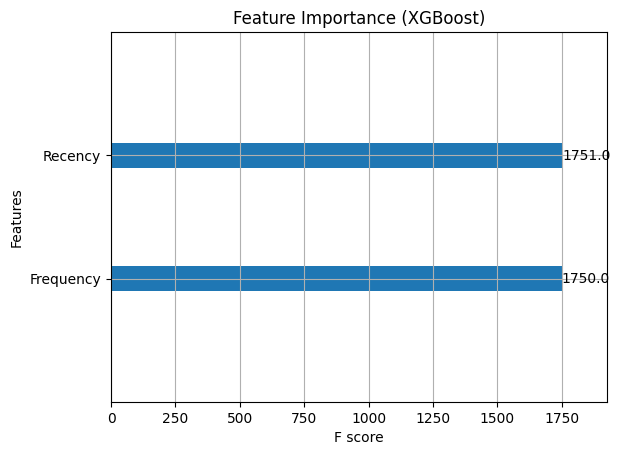

In [55]:
# Plot feature importance
# Show which features (Recency or Frequency) were more important
xgb.plot_importance(model_xgb)
plt.title("Feature Importance (XGBoost)")
plt.show()

**XGBoost Results Summary**
* **RMSE:** 5561.93 - The model's predictions are, on average, ~₤5562 off from actual values.
* **R² Score:** 0.341 - XGBoost explains 34.1% of the variance in Monetary — slightly worse than our log-regression model (R² = 0.459)

**Feature Importance, from the plot**
* Recency and Frequency are equally important for XGBoost.
* Very balanced - This suggests that both how recent and how often a customer buys are equally predictive of spend.

**Quick Notes:**

* **RMSE (Root Mean Squared Error)** tells us, on average, how far our model's predictions are from the actual values. Lower is better — it means the model is making more accurate predictions.
* **R² Score (Coefficient of Determination)** shows how well the model explains the variation in the target variable (Monetary). A score closer to 1 means the model fits the data better. For example, R² = 0.45 means the model explains 45% of the variation in customer spend.
* **X-axis (F score), from the plot:** How often each feature was used to split the data across all decision trees in the model
→ Higher = more important

**Step 7: Choosing the Best Model for CLTV Prediction**

**Model Comparison**
* OLS Regression (raw) - R² Score: 0.343	—	Skewed, violated assumptions.
* OLS Regression (log) - R² Score: 0.459	—	 **Best-performing so far**.
* XGBoost - R² Score: 0.341	RMSE: 5561.93 - Slightly less accurate, but more robust.

Our log-transformed linear regression model is the best performer, but XGBoost still adds value by handling nonlinearities and showing that both Recency and Frequency matter equally.

**We will continue to use the log-linear model.**
Our log-transformed regression model was the most accurate (R² = 0.459) and had the best statistical behavior. But since it predicts the log of Monetary, we need to convert the output back to the normal scale using np.exp().

**Step 8: Predicting CLTV with Our Log-Linear Model**

In [56]:
# Define the function
import numpy as np
import pandas as pd

def predict_cltv(recency, frequency, model=log_model):
    """
    Predict Customer Lifetime Value using a log-linear regression model.

    Parameters:
    -----------
    recency : int or float
        Days since the customer's last purchase
    frequency : int or float
        Total number of purchases made by the customer
    model : statsmodels OLS object
        A trained log-linear regression model (e.g., log_model)

    Returns:
    --------
    cltv : float
        Predicted Customer Lifetime Value in original currency (not log scale)
    """
    # Step 1: Create input data in the same column order as training
    new_data = pd.DataFrame({'const': [1], 'Recency': [recency], 'Frequency': [frequency]})

    # Step 2: Predict log(CLTV)
    log_cltv = model.predict(new_data)

    # Step 3: Convert back from log scale to currency
    cltv = np.exp(log_cltv)[0]

    return cltv

In [57]:
# Predict for a customer with 4 purchases and last purchase 12 days ago
predicted = predict_cltv(recency=12, frequency=4)
print(f"Predicted CLTV: £{predicted:.2f}")

Predicted CLTV: £1213.85


**Final Summary**

In this project, we built a machine learning model to **predict Customer Lifetime Value (CLTV)** using just two simple behavioral metrics: Recency (days since last purchase) and Frequency (number of purchases). By training a log-linear regression model, we were able to estimate how much revenue a customer is likely to generate in the future.

* **You don’t need to wait months to calculate CLTV.
Our model allows you to estimate it immediately based on available behavioral data** — so you can take action right away.

This enables businesses to:

* Prioritize high-value customers early
* Personalize marketing and retention strategies
* Allocate budget more effectively

We also created a reusable prediction function that allows you to:

* Predict CLTV for a single customer
* Or run batch predictions for all customers at once

We compared different models (including XGBoost), evaluated results using R² and RMSE, and confirmed that the log-transformed linear regression was the best performer — offering strong accuracy and easy interpretation.

This approach turns basic customer data into powerful predictions, helping teams make data-driven decisions without delays.